In this notebook, we go through various labeling methods for supervised training, especially classification.
The most typically used one is fixed time horizon labeling. Although it is easy to define and be used, an investor would not be interested in exactly fixed forwarded time return and it looses path dependent information.

We will define path dependent labeling methods. The most of implementations will be found at `finance_ml/labeling`.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

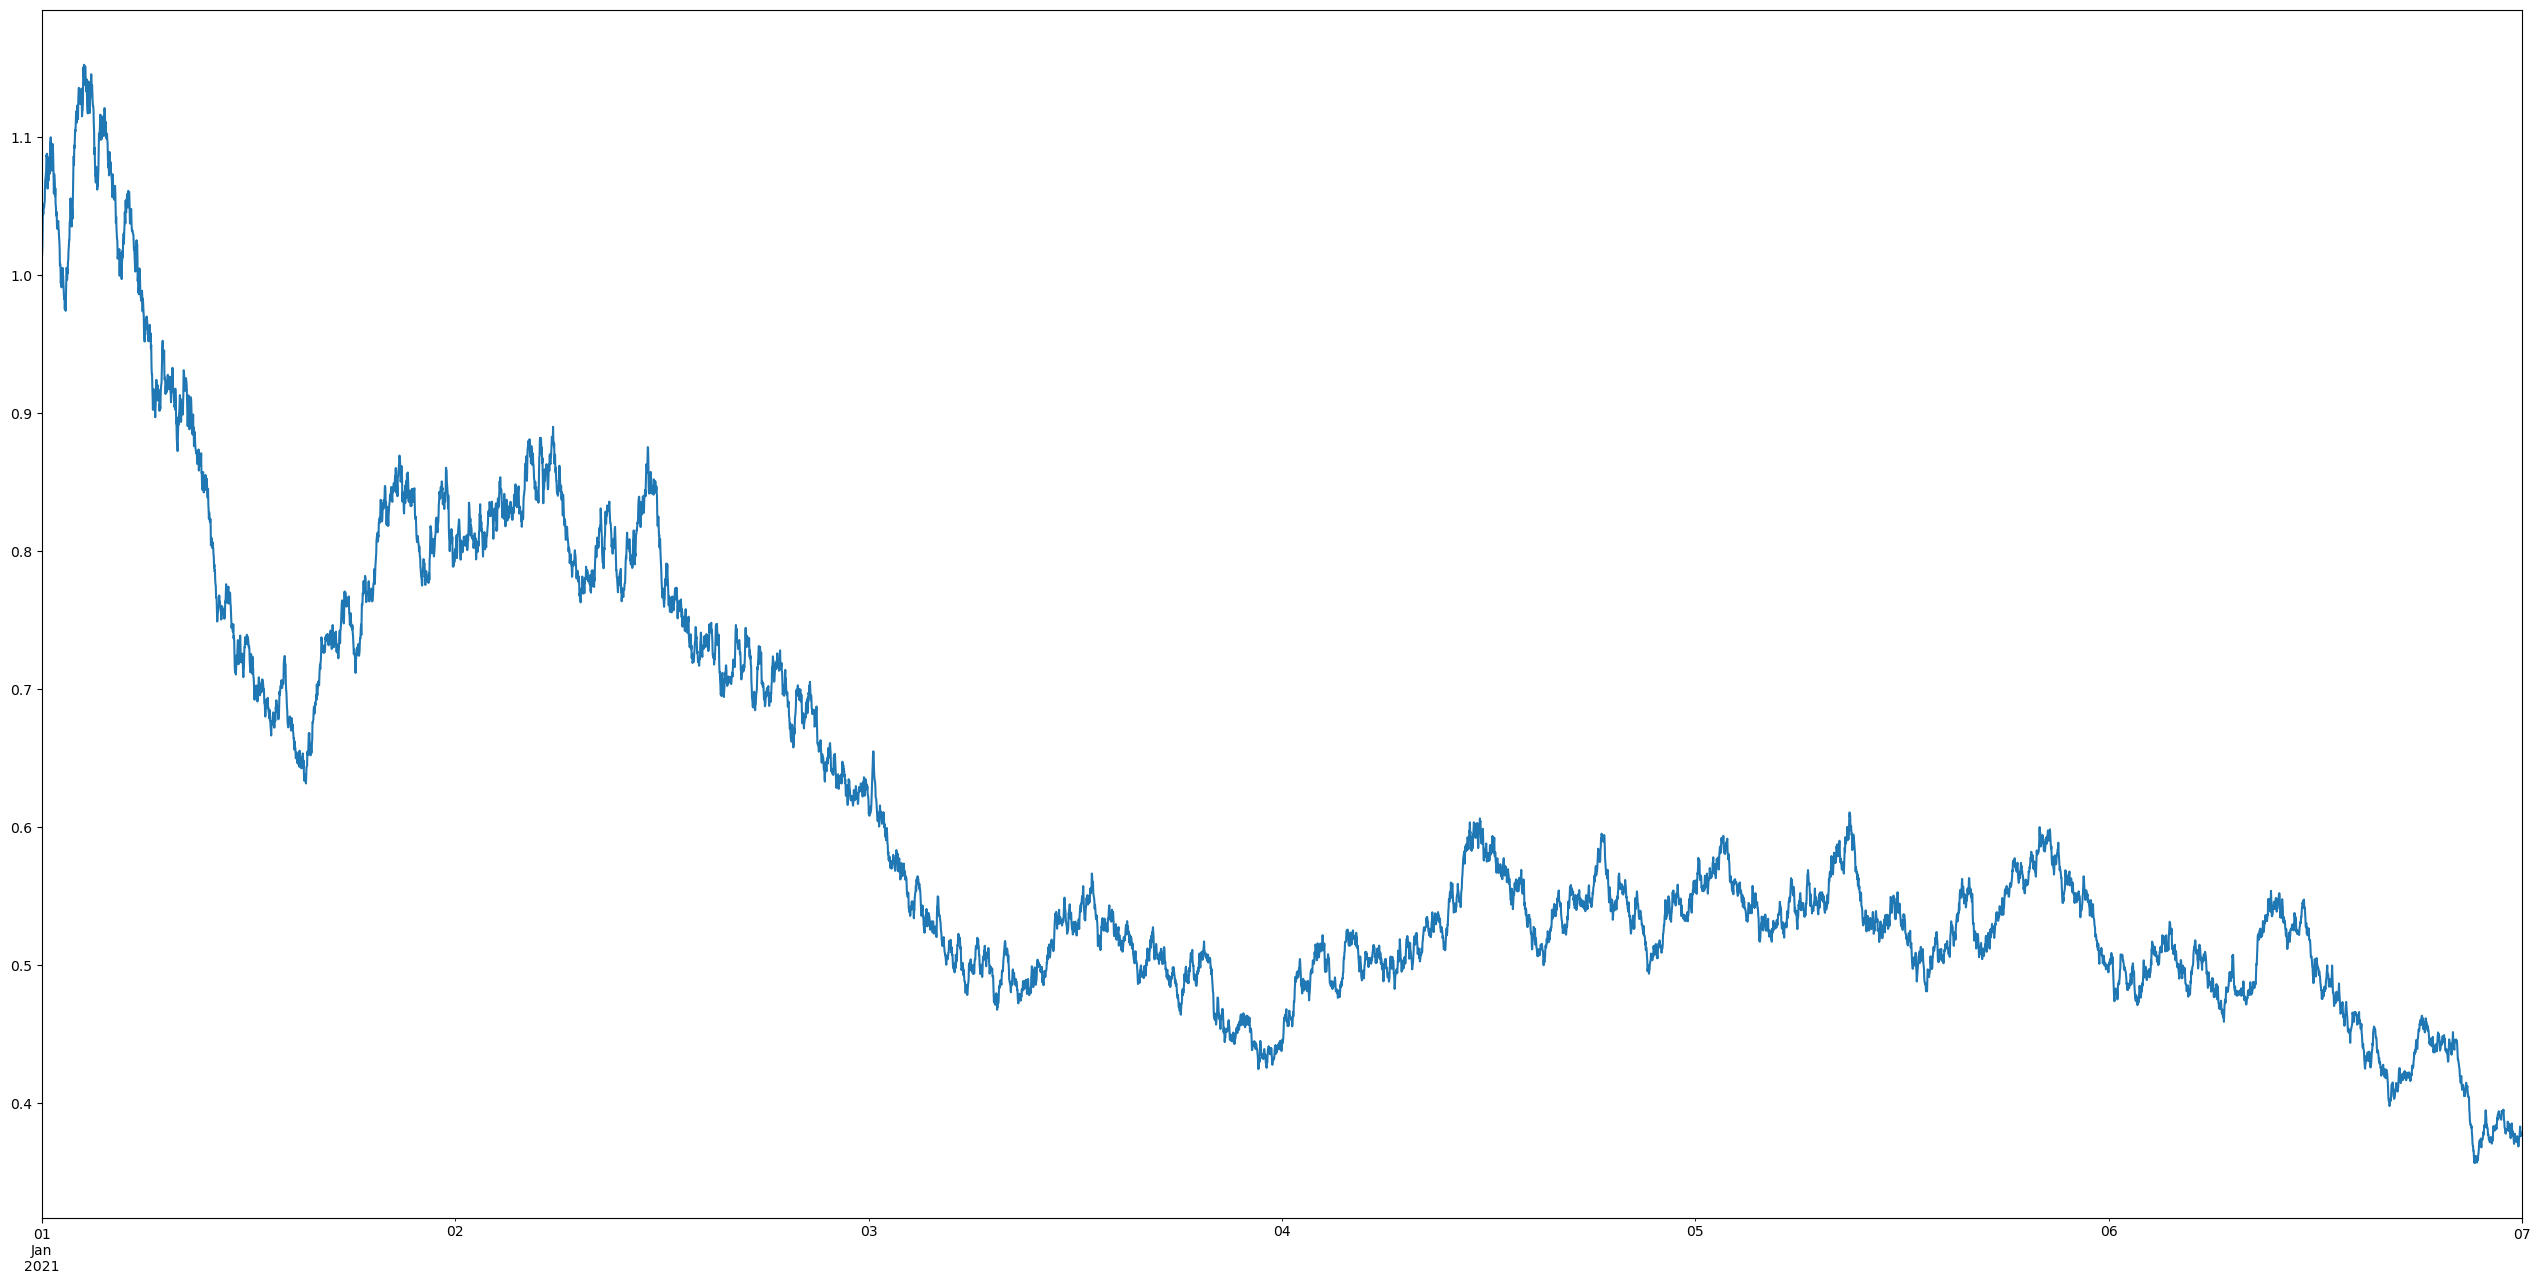

In [2]:
from datetime import datetime

np.random.seed(0)
st = datetime(2021, 1, 1)
end = datetime(2021, 1, 7)
index = pd.date_range(st, end, freq="60S")
vol = 5. / np.sqrt(60 * 24 * 365) # annualized vollatility is 500% 
df0 = pd.Series(np.random.normal(0, vol, index.shape[0])).cumsum()
df0 = np.exp(df0)
df0.index = index
df0.plot();

# Triple Barrier Method

Triple barrier method label whether price path within certain time frame reaches user defined thresholds.

In [25]:
from finance_ml.labeling import get_barrier_labels
import multiprocessing as mp

labels = get_barrier_labels(df0,
                            trgt=5e-3,
                            sltp=1,
                            seconds=300,
                            sign_label=False, #if  True, label based on sign of return when touching vertical line
                            num_threads=mp.cpu_count())

2021-06-08 02:19:10.472006 100.0% get_touch_idx done after 0.01 minutes. Remaining 0.0 minutes.


In [26]:
labels.head()

,ret,label,t1,type
2021-01-01 00:00:00,0.009555,1.0,2021-01-01 00:02:00,tp
2021-01-01 00:01:00,0.006773,1.0,2021-01-01 00:02:00,tp
2021-01-01 00:02:00,0.015575,1.0,2021-01-01 00:03:00,tp
2021-01-01 00:03:00,0.012963,1.0,2021-01-01 00:04:00,tp
2021-01-01 00:04:00,-0.006717,-1.0,2021-01-01 00:05:00,sl


In [27]:
print(np.unique(labels['type']), np.unique(labels['label']))

['sl' 't1' 'tp'] [-1.  0.  1.]


# Meta Labeling

In some cases, you may know if you wanna long or short but you need to know filter some signals out and the proper betting size. For example, you get high recall but low precision signals. In this case, you wanna increase the quality of the prediction to filter out some of the signals. Controlling betting size is continuous compared to filtering out.

One way to generate betting size is utilizing confidence signals on binary classification output.


### Sharpe Ratio Bet Size

Assume that you have probability $p$. Positive is take profit $\pi$ while negative is $-\pi$ at loss. Mean is $\mu = \pi (2p - 1)$ and standard deviation is $\sigma = 4\pi \sqrt{p(1 - p)}$
$$z = \frac{p - 0.5}{\sqrt{p(1 - p)}}$$
If you get the estimated confidence level $\hat{p}$, you can use this as
$$\hat{z} = \frac{\hat{p} - 0.5}{\sqrt{\hat{p}(1 - \hat{p})}}$$

Assuming that this signals is distributed according to normal standard distribution, $m = 2 Z[\hat{z}] - 1$ as a betting size ranged [-1, 1].


### Ensemble Bet Size

Assume that you have N predictors on each meta label and predictions $y_i = \{0, 1\}, \forall i = 1, ..., N$. Let $p$ be unknown true probability and $\sum_i y_i \sim B[n, p]$. Then, you can get t-statistics
$$\hat{p} = \frac{1}{N} \sum_i y_i$$
$$ t = \frac{(\hat{p} - 0.5)}{\sqrt{\hat{p} (1 - \hat{p})}} \sqrt{N}$$

t is t-statistics of null hypothesis of p = 0.5.
you can use this to $m = 2 t_{N - 1}[t] - 1$
where $t_{N - 1}$ cumulative distribution function of t-student of N-1 degrees of freedom. m is ranged [-1, 1].

We will go thorough simple CUSUM based trend following labels.

In [6]:
from finance_ml.labeling.betsides import cusum_side

sides = cusum_side(df0, 3e-2)

2021-06-08 02:12:08.830436 100.0% _cusum_side done after 0.0 minutes. Remaining 0.0 minutes.


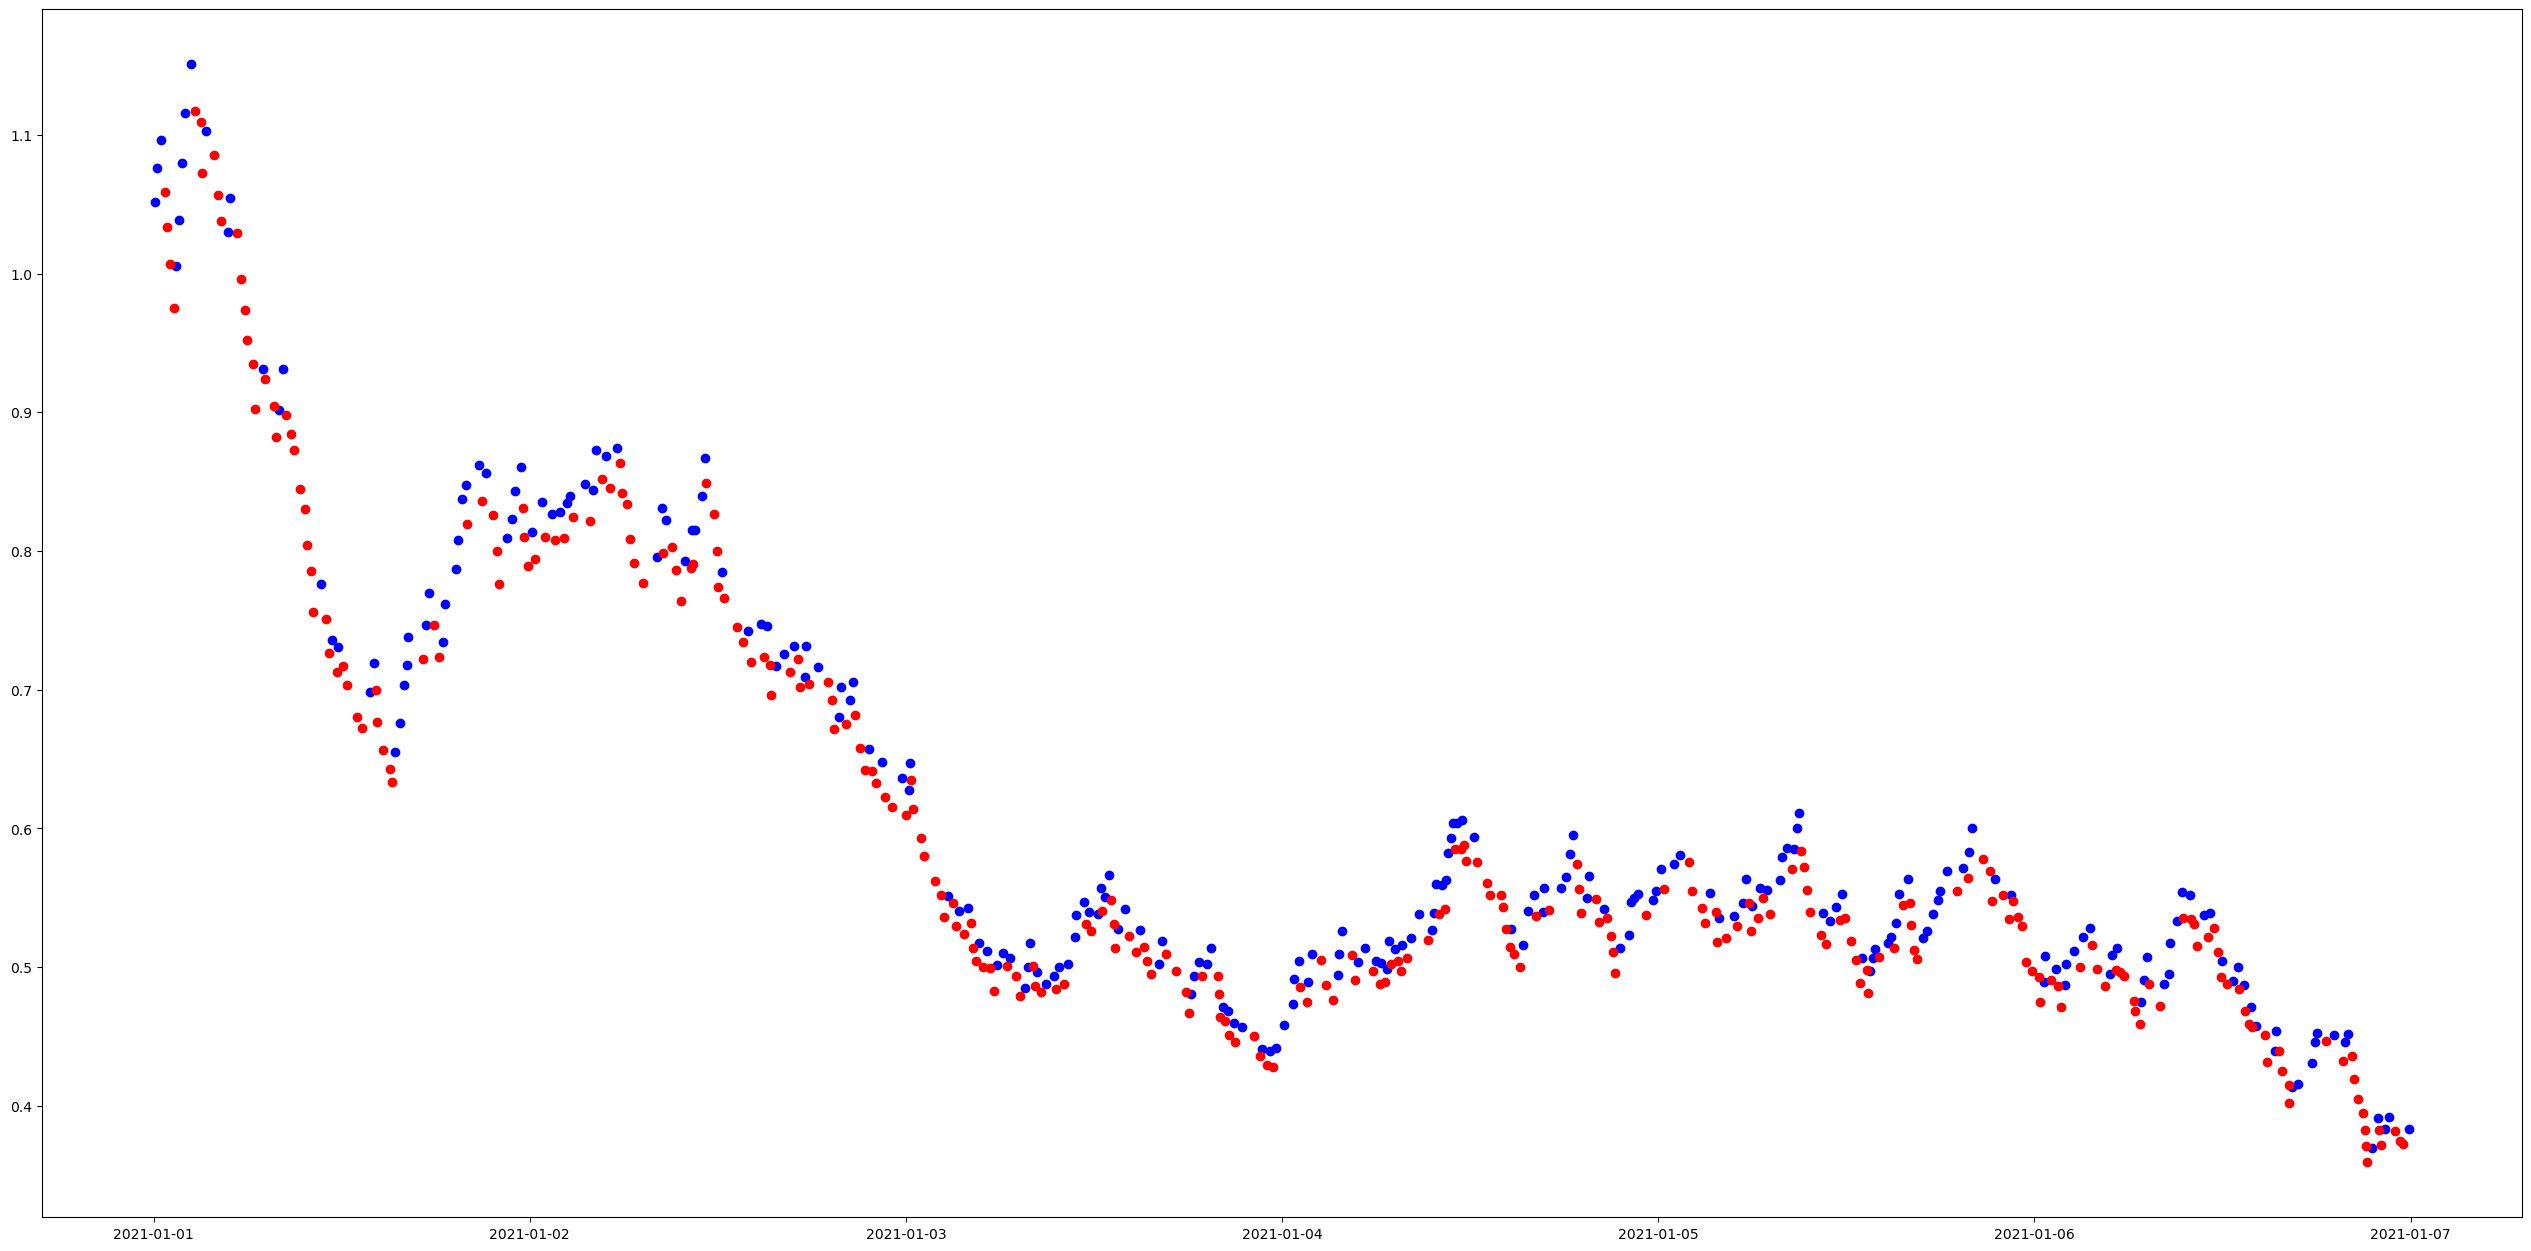

In [7]:
plt.scatter(sides[sides == 1].index, df0[sides[sides == 1].index], color='b');
plt.scatter(sides[sides == -1].index, df0[sides[sides == -1].index], color='r');

In [8]:
sides.head()

2021-01-01 00:04:00    1
2021-01-01 00:15:00    1
2021-01-01 00:29:00    1
2021-01-01 00:42:00   -1
2021-01-01 00:53:00   -1
dtype: int64

In [9]:
from finance_ml.labeling import get_barrier_labels
import multiprocessing as mp

labels = get_barrier_labels(df0,
                            trgt=5e-3,
                            sltp=1,
                            seconds=300,
                            sign_label=False, #if  True, label based on sign of return when touching vertical line
                            side=sides,
                            num_threads=mp.cpu_count())

2021-06-08 02:12:11.996708 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.
/home/tom/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [10]:
labels

,ret,side,label,t1,type
2021-01-01 00:04:00,-0.006717,1,0.0,2021-01-01 00:05:00,sl
2021-01-01 00:15:00,0.010358,1,1.0,2021-01-01 00:16:00,tp
2021-01-01 00:29:00,-0.015978,1,0.0,2021-01-01 00:33:00,sl
2021-01-01 00:42:00,-0.013545,-1,0.0,2021-01-01 00:43:00,sl
2021-01-01 00:53:00,-0.005319,-1,0.0,2021-01-01 00:57:00,sl
...,...,...,...,...,...
2021-01-06 22:37:00,0.005107,1,1.0,2021-01-06 22:40:00,tp
2021-01-06 23:00:00,0.007317,-1,1.0,2021-01-06 23:02:00,tp
2021-01-06 23:21:00,-0.011446,-1,0.0,2021-01-06 23:22:00,sl
2021-01-06 23:32:00,0.005645,-1,1.0,2021-01-06 23:33:00,tp


In [11]:
print(np.unique(labels['type']), np.unique(labels['label']))

['sl' 't1' 'tp'] [0. 1.]


Next, we check the signal translation.

In [19]:
np.random.seed(0)
probs = np.random.uniform(0, 1, 10000)

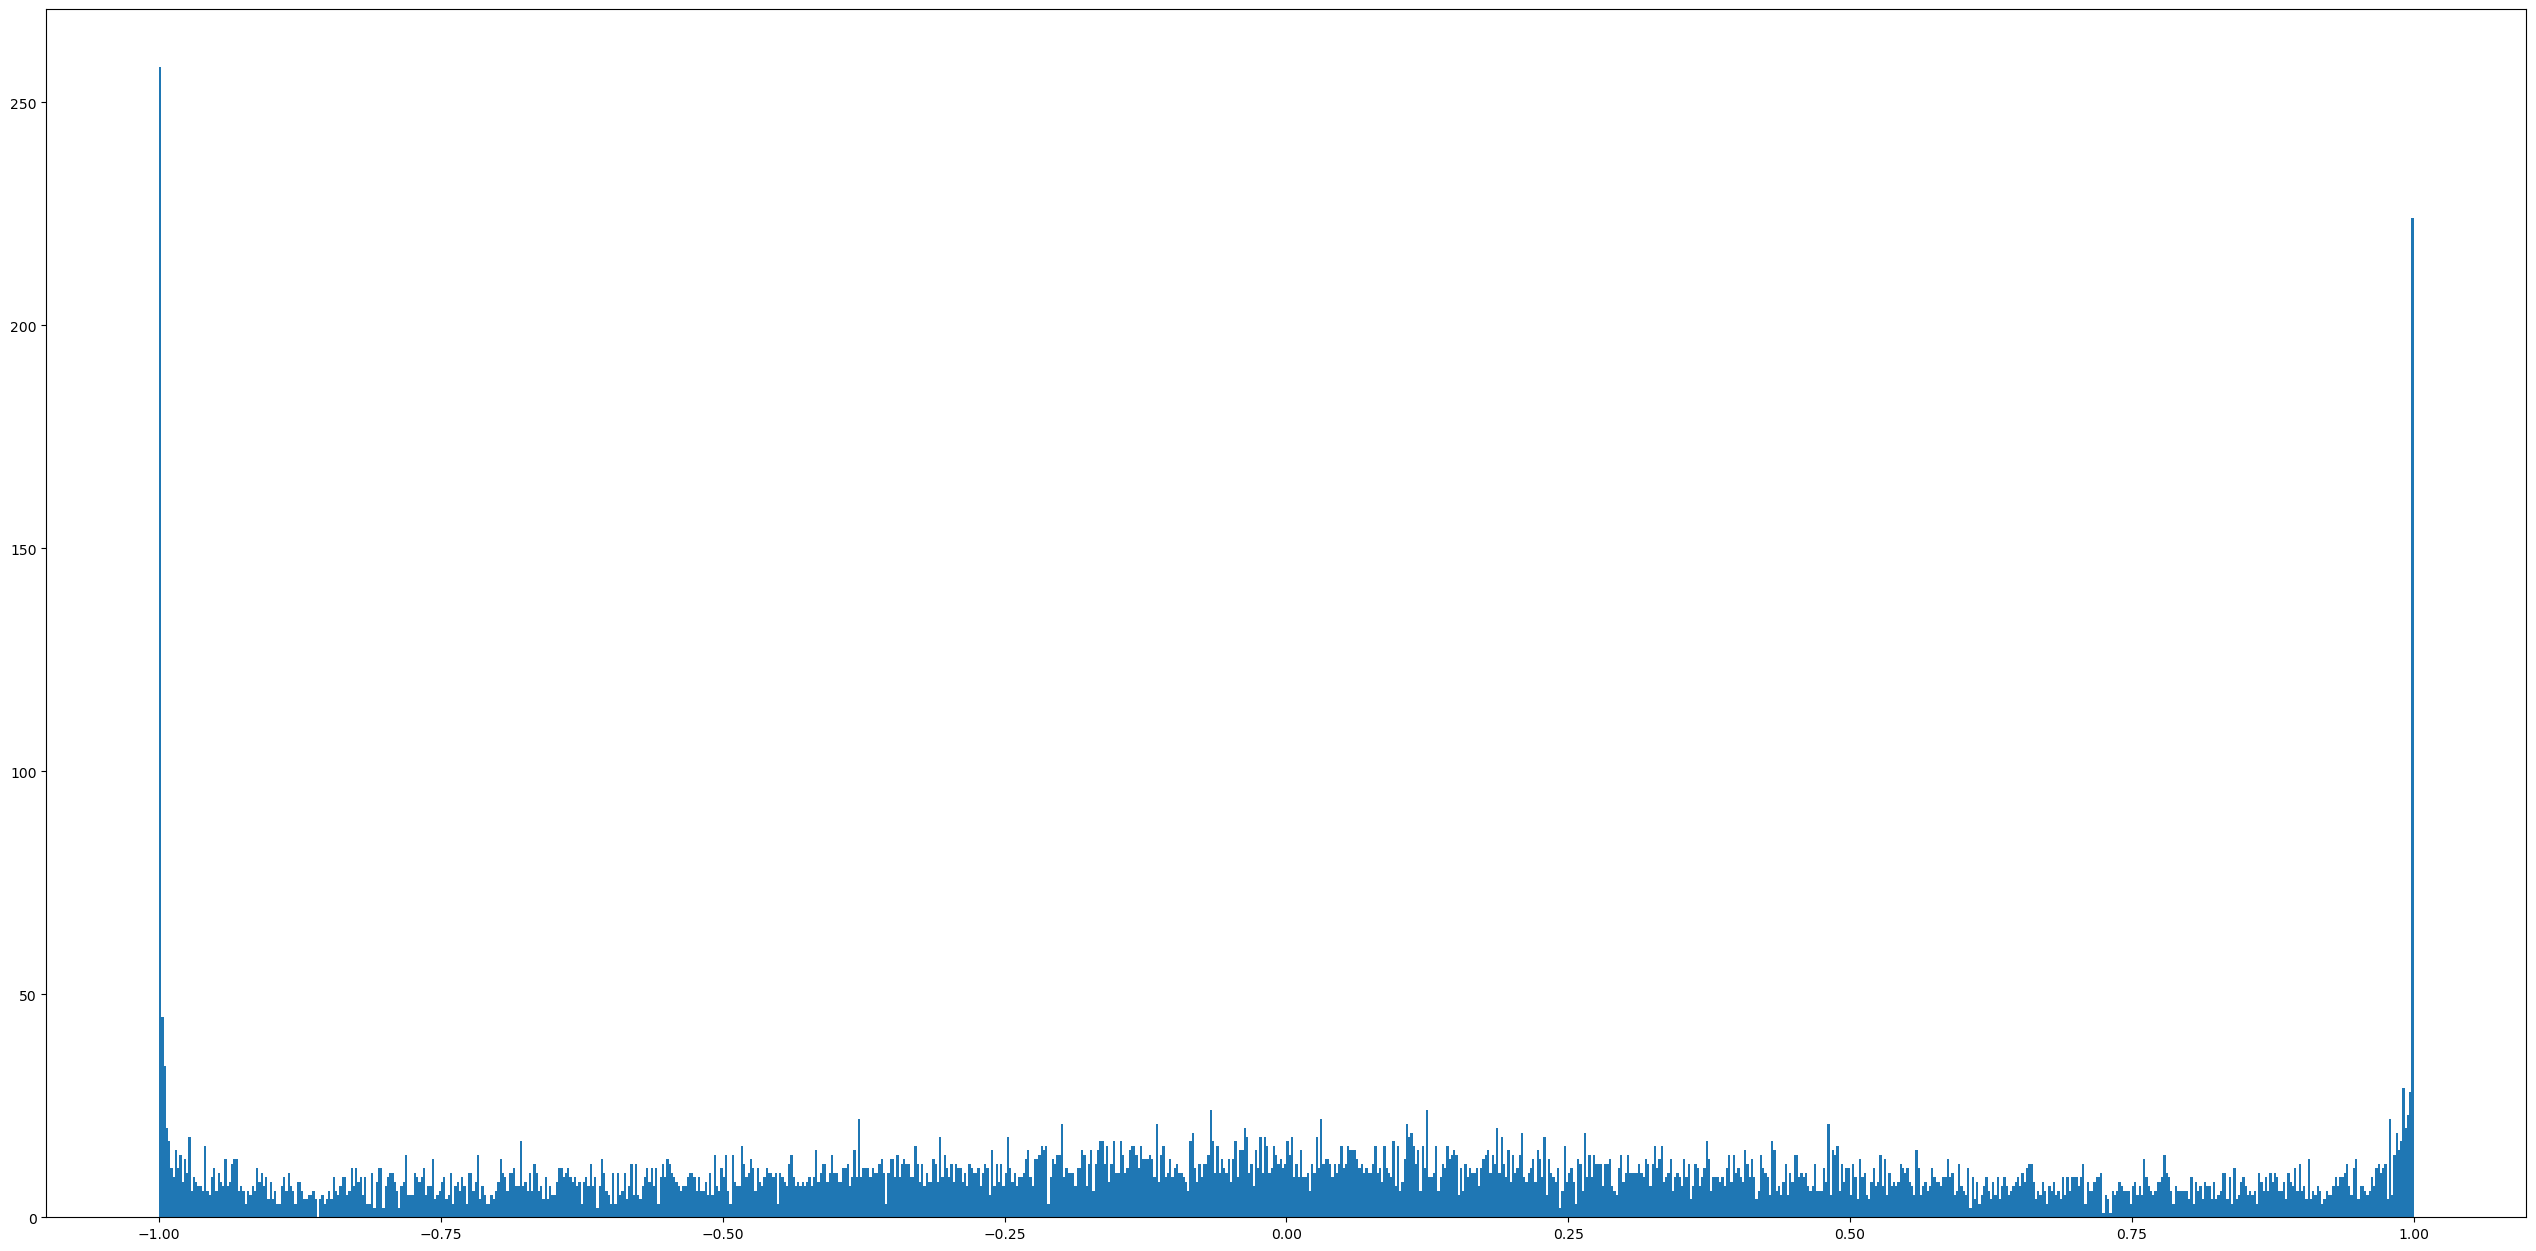

In [22]:
from finance_ml.labeling.betsizes import get_gaussian_betsize

signals = get_gaussian_betsize(probs)
plt.hist(signals, bins=1000);

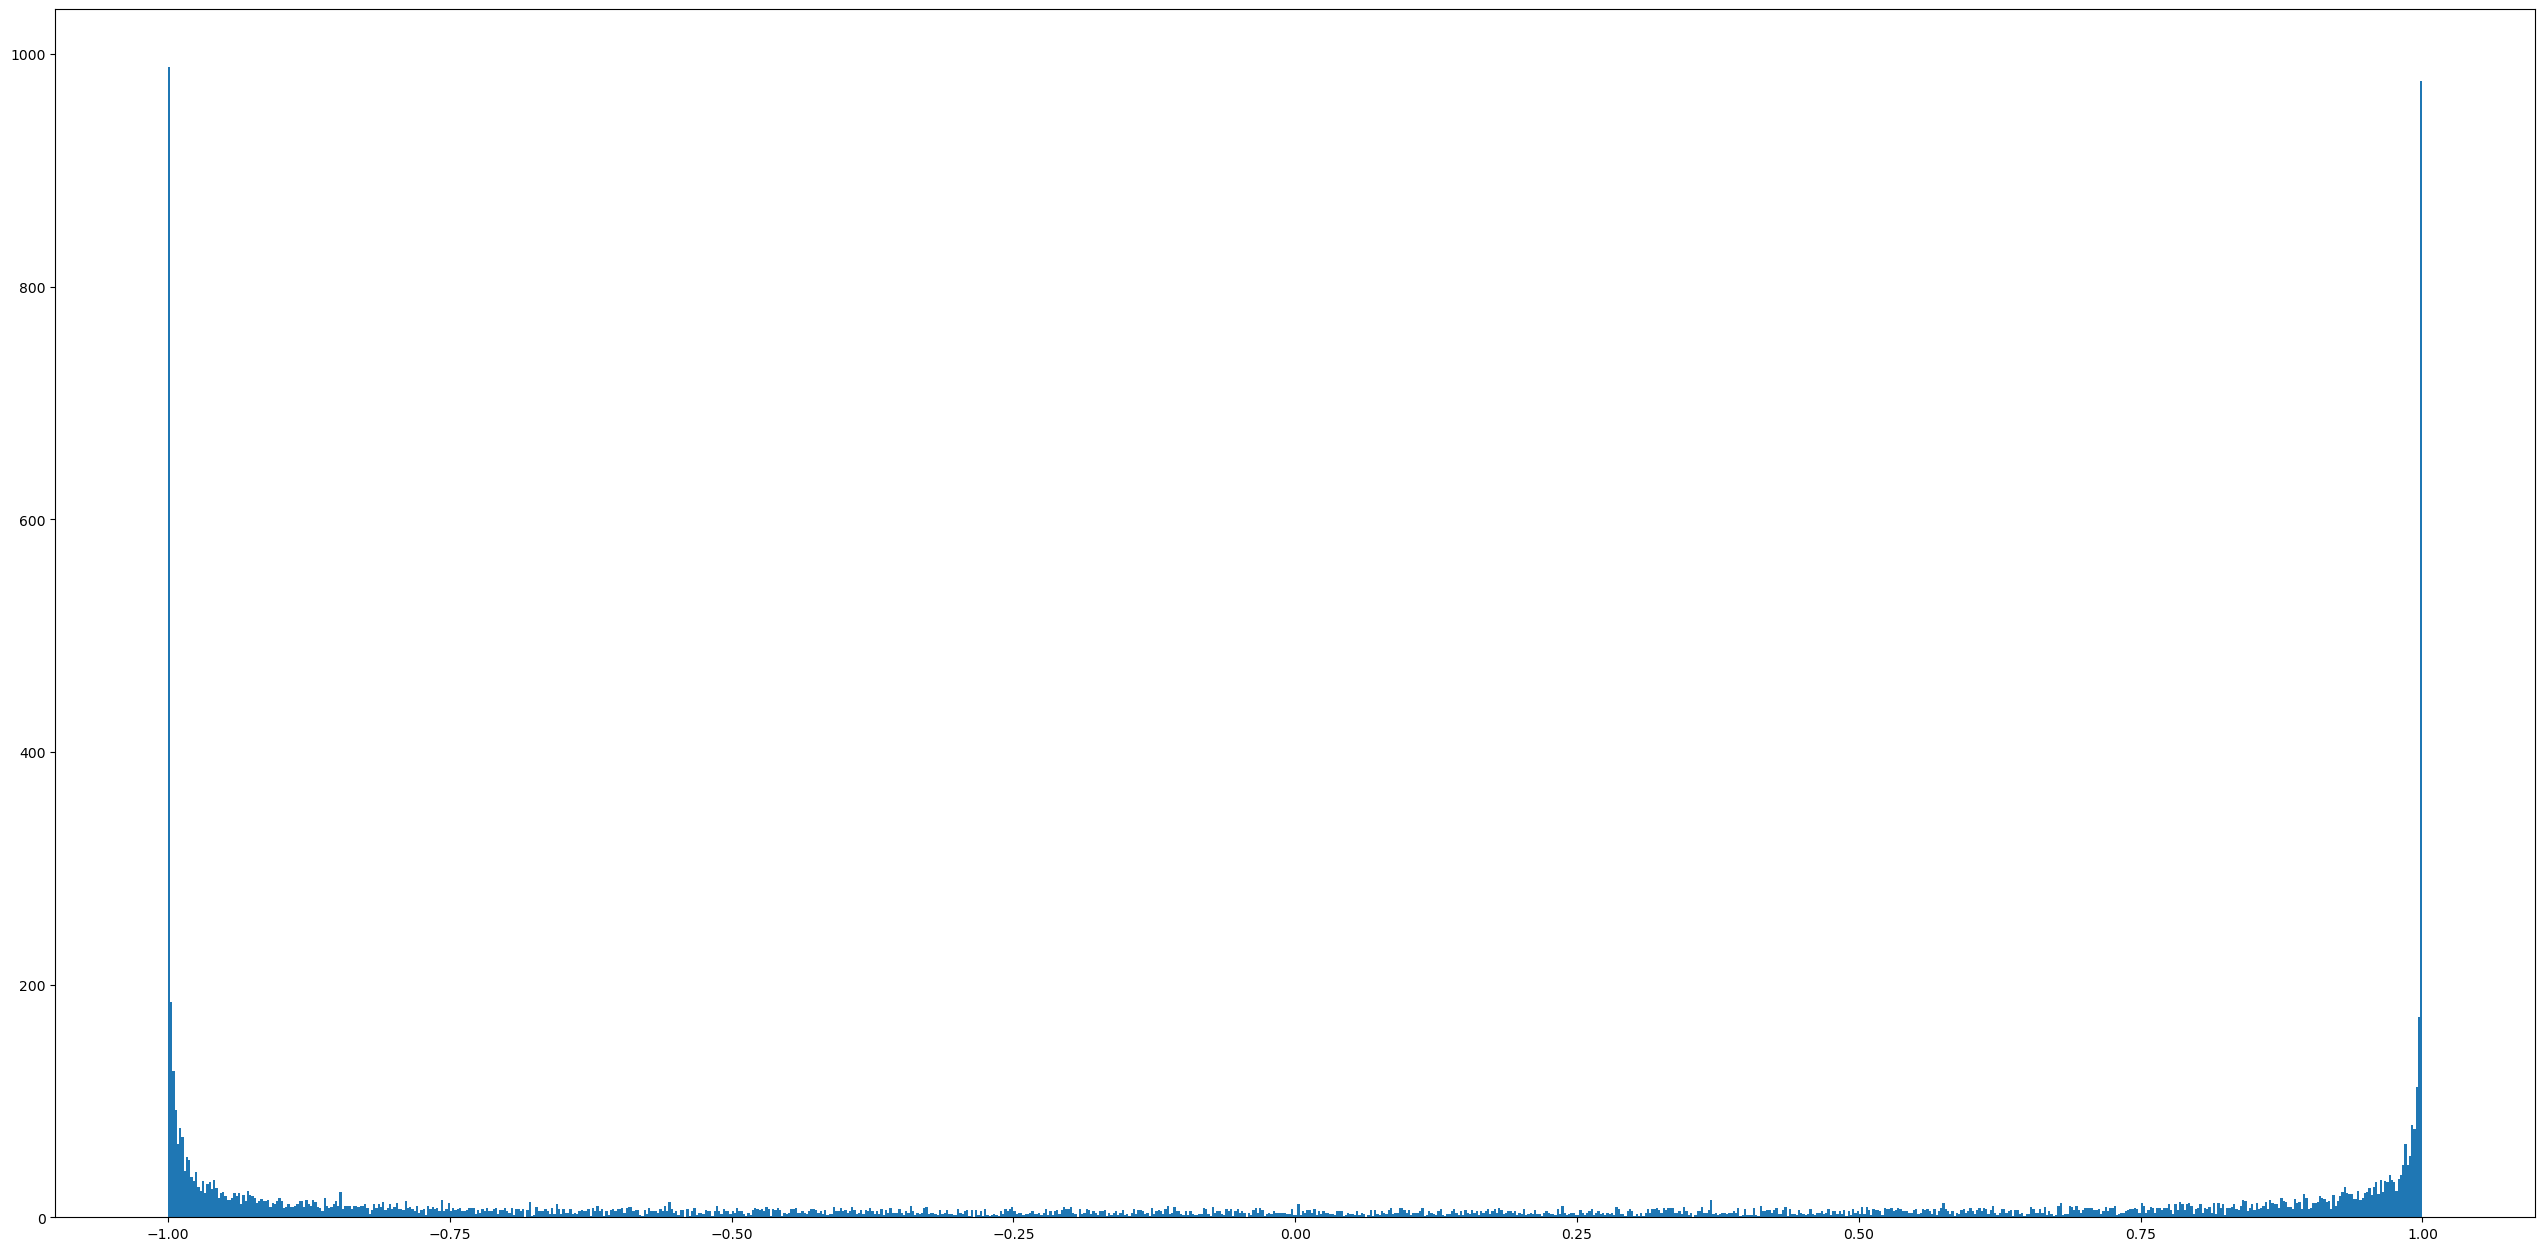

In [24]:
from finance_ml.labeling.betsizes import get_tstats_betsize

signals = get_tstats_betsize(probs, N=10)
plt.hist(signals, bins=1000);

# Trend Scanning Method

This method label the strength of trend through the following linear model

$$x_{t + l} = \beta_0 + \beta_1 l + \epsilon_{t + l} \forall l = 0, ..., L - 1$$
$$\hat{t}_{\hat{\beta}_1} = \frac{\hat{\beta}_1}{\hat{\sigma}_{\hat{\beta}_1}}$$
where L is an user-defined look forward period.  $|\hat{t}_{\hat{\beta}_1}|$ quantifies the strength of trend.

The implementation will be found at finance_ml/labeling/trend.py

2021-06-08 02:19:31.566671 100.0% _get_bins_from_trend done after 0.04 minutes. Remaining 0.0 minutes..


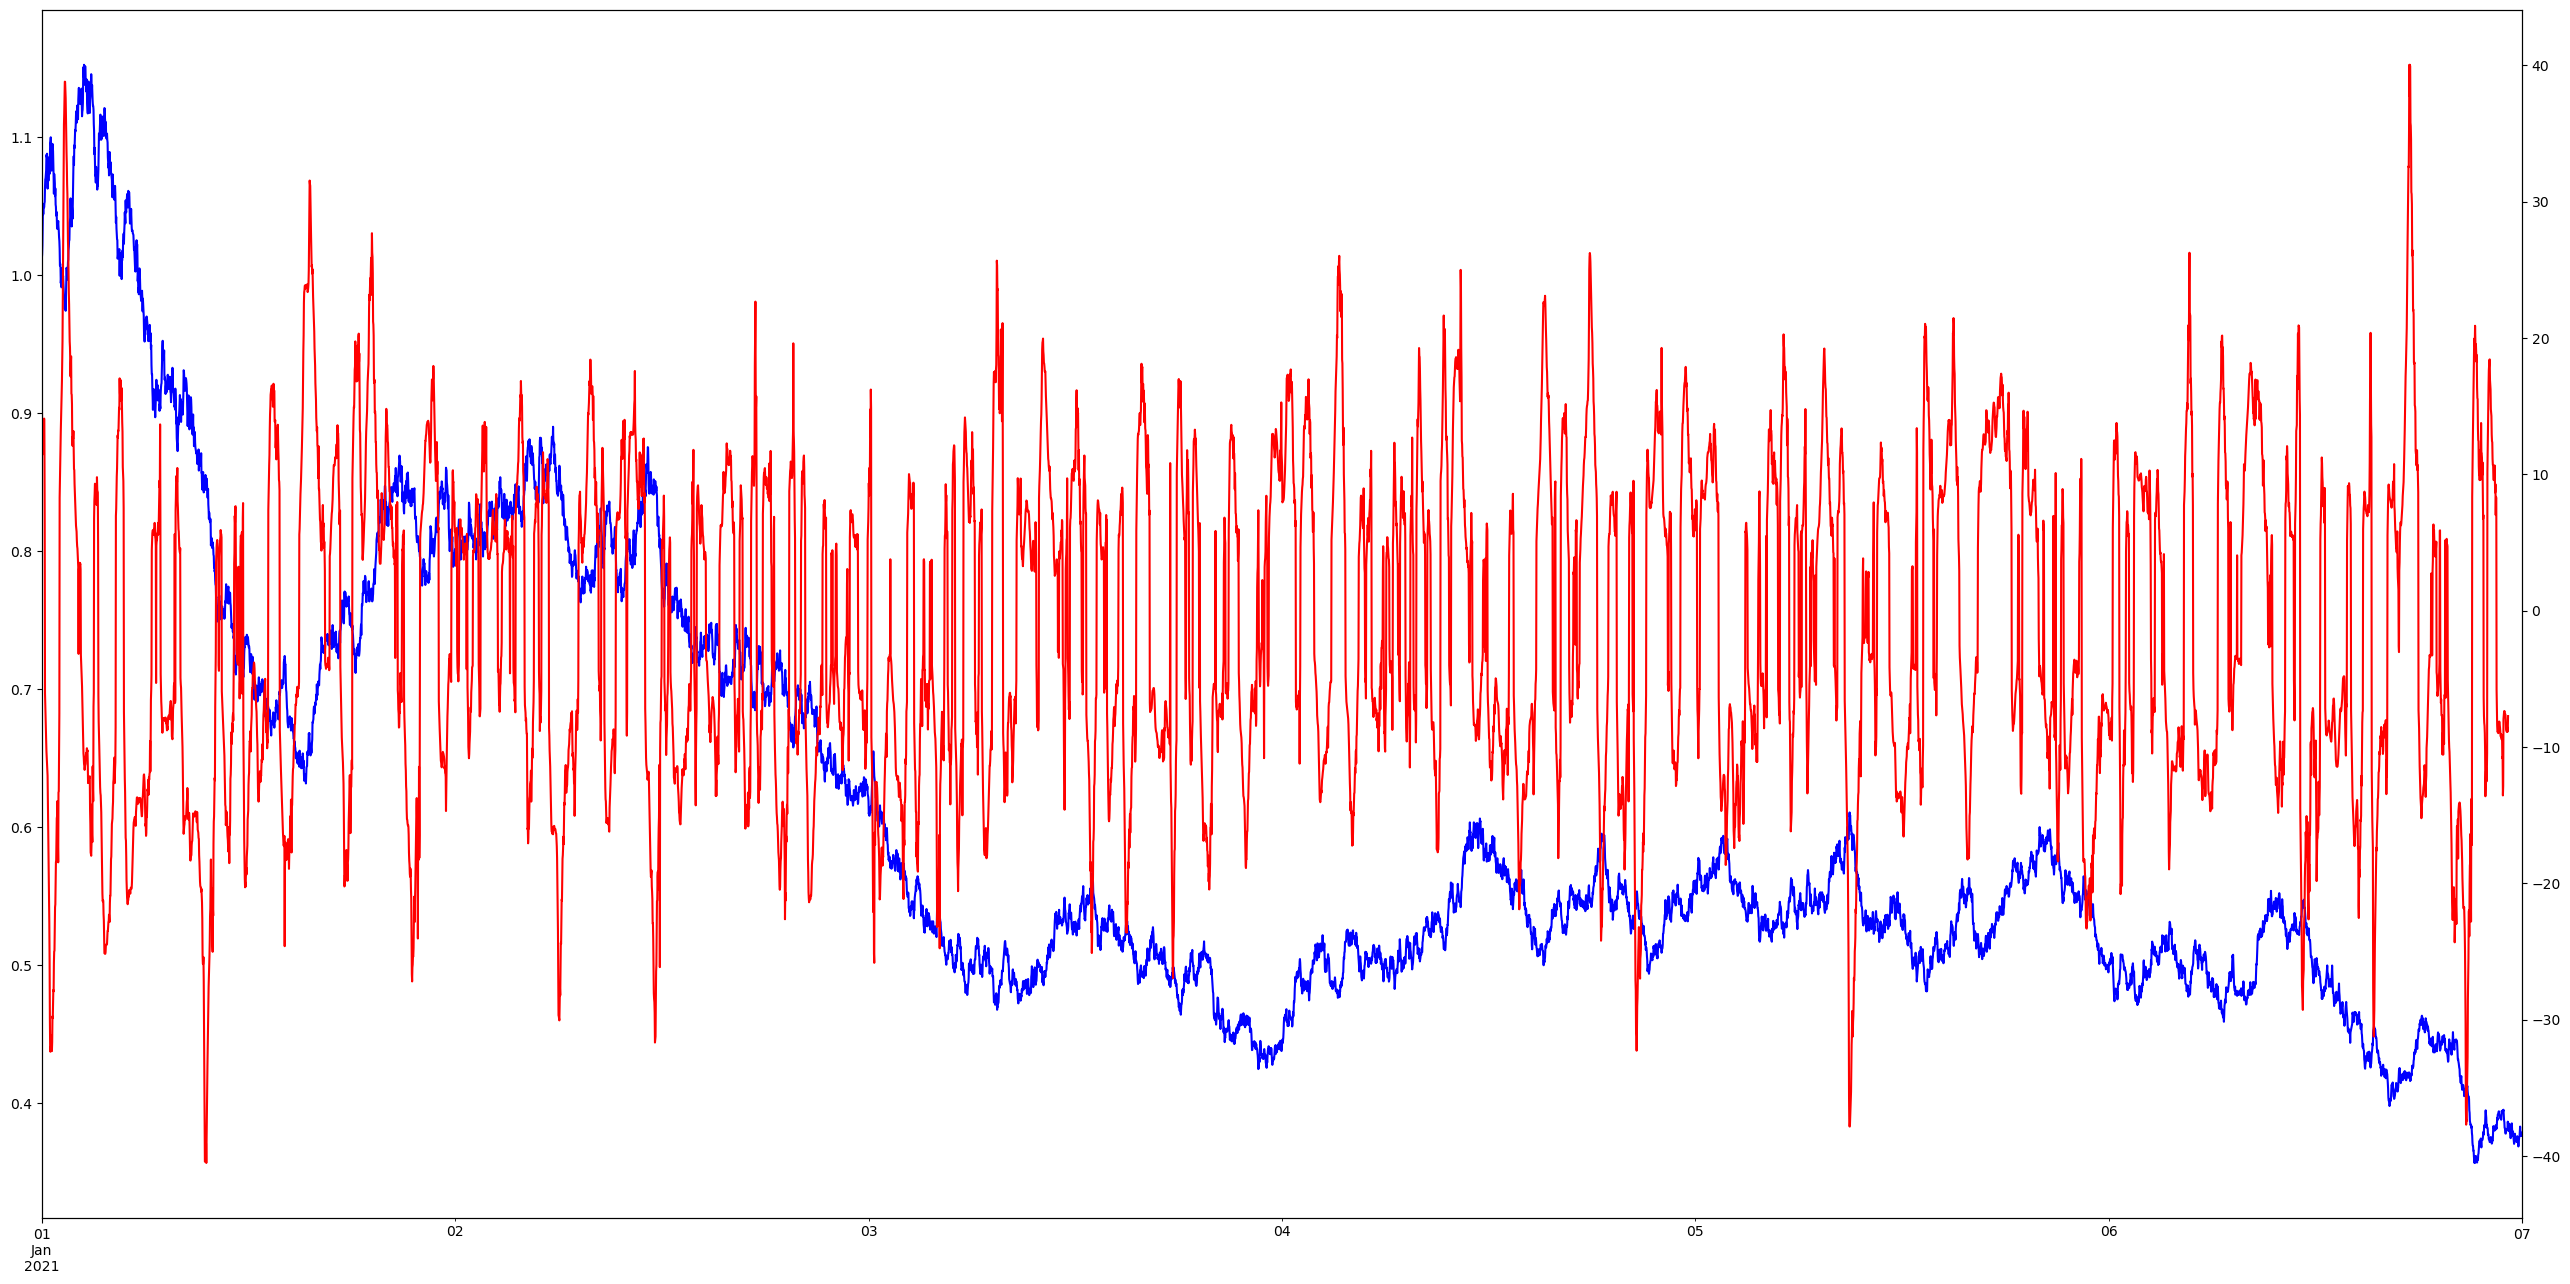

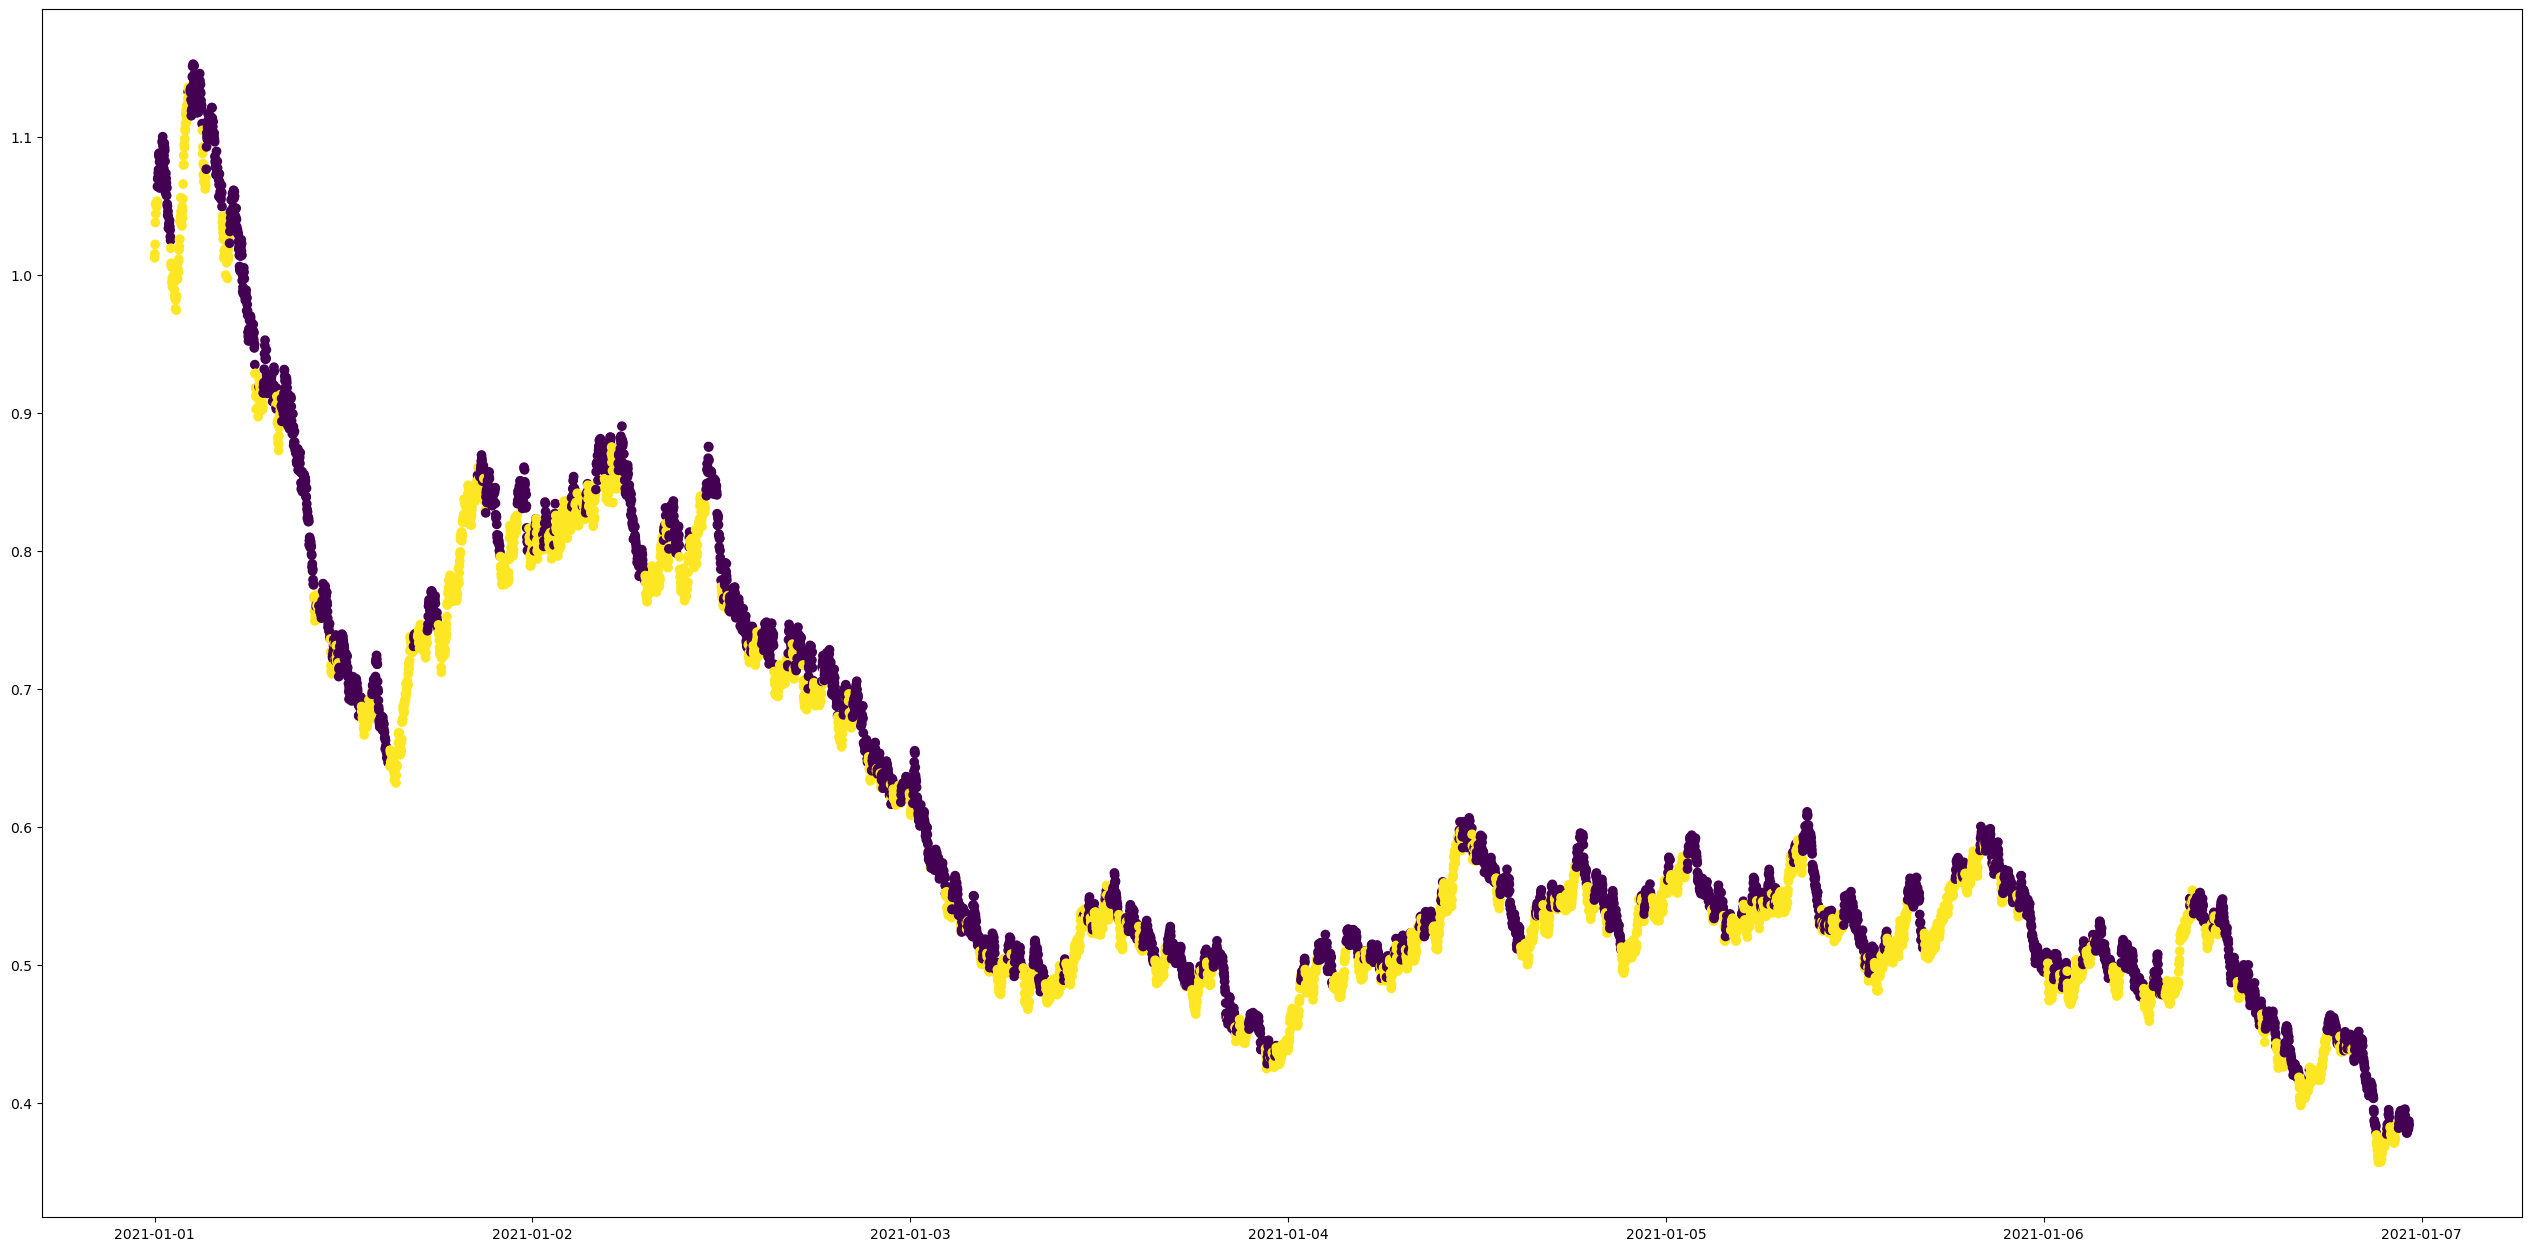

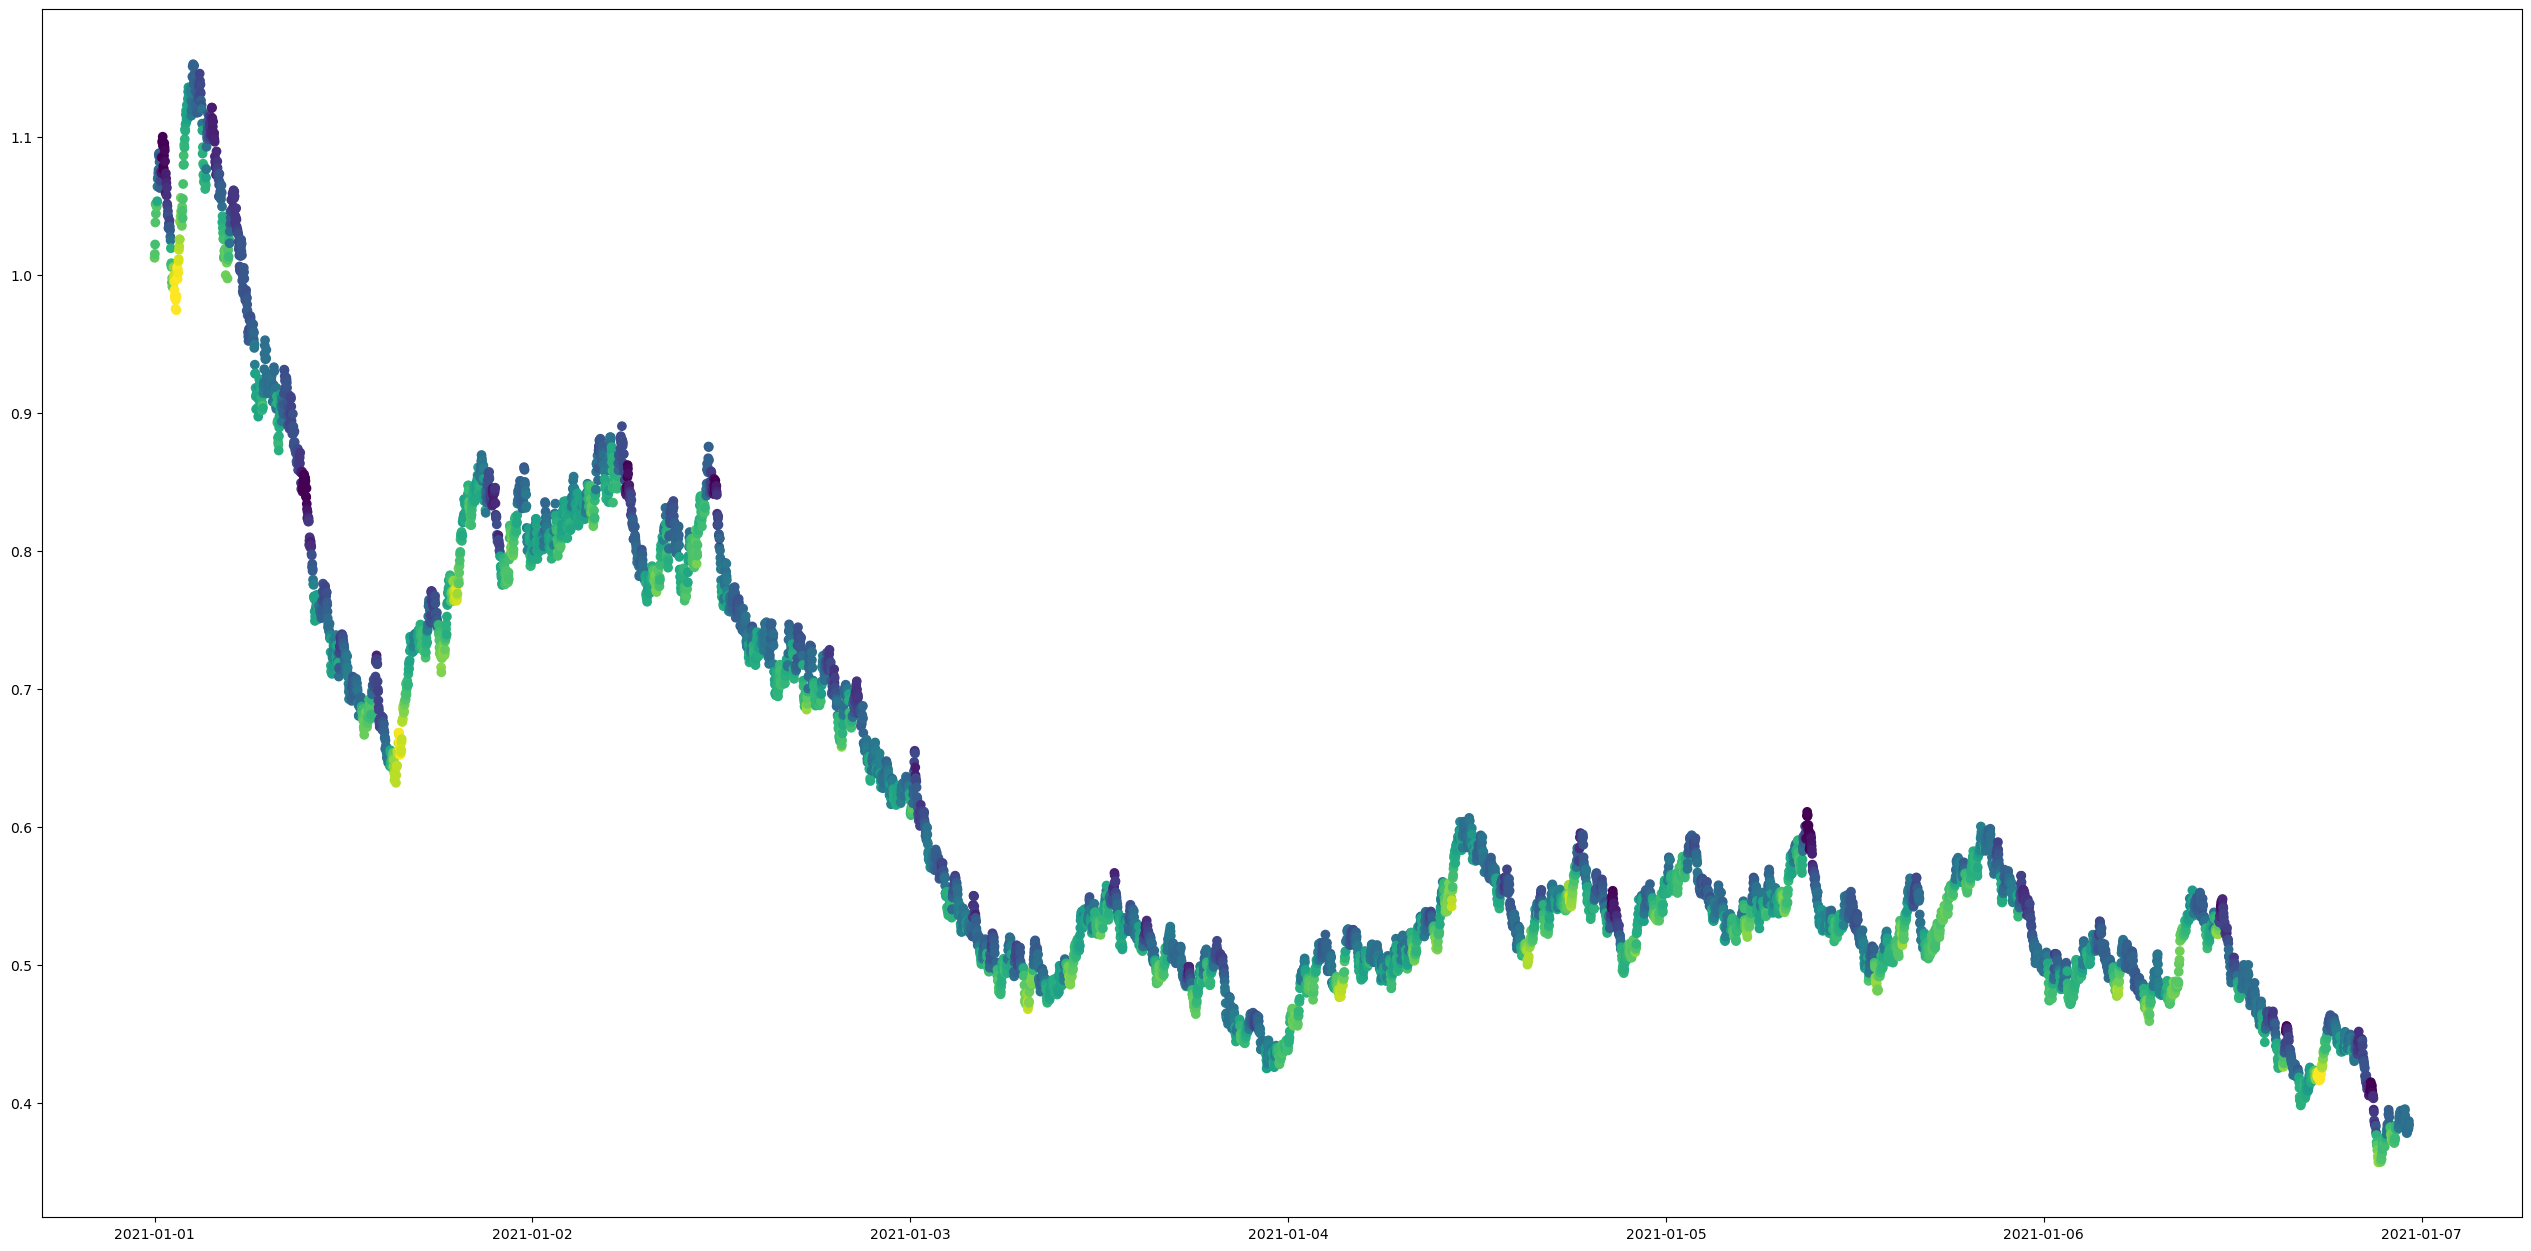

In [28]:
from finance_ml.labeling import get_bins_from_trend


max_step = 50
min_step = 10
step = 3
df1 = get_bins_from_trend(df0, max_step, min_step, step)
plt.figure()
df0.plot(color='b');
df1['t_val'].plot(secondary_y=True, color='r');
plt.figure()
plt.scatter(df1.index, df0.loc[df1.index].values, c=df1['bin'].values, cmap='viridis');
plt.figure()
t_vals = df1['t_val'].values
t_vals = np.clip(t_vals, -30.0, 30.0)
plt.scatter(df1.index, df0.loc[df1.index].values, c=t_vals, cmap='viridis');